In [1]:
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
logs_dir = Path.cwd() / Path("relogs")
#logs_dir = Path.home() / Path("ordner", "mthesis","live_scobi_logs")
logs_dir = Path.home() / Path("ordner", "mthesis", "exp_archive", "live_scobi_logs")
out_dir = Path.cwd() / Path("plots")

def get_dfs_for_env(env, smooth_window=5):
    exp_list = []
    for p in logs_dir.iterdir():
        if env in p.name:
            seed = p.name.split("seed")[-1]
            exp_list.append((seed, p))
    if len(exp_list) == 0:
        return None
    exp_str_list = " ".join([str(n[0]) for n in exp_list])
    print(f"Environment: {env}\t|\tSeeds: {exp_str_list}")

    data_dict = {}
    for seed, log_dir in exp_list:
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']
                for tag in scalar_list:
                    for s in acc.Scalars(tag):
                        if seed in data_dict.keys():
                            data_dict[seed].append((tag, s.step, s.value, seed))
                        else:
                            data_dict[seed] = []
    returns_by_seeds = []
    entropies_by_seeds = []
    steps_by_seeds = []

    for k, v in data_dict.items():
        df = pd.DataFrame(v, columns=["tag", "step", "value", "seed"])
        df.step = df.step / 1000000

        returns = df[df["tag"] == "rewards/avg_return"].copy()
        returns = returns.sort_values(by="step", ascending=True)
        returns = returns.iloc[::10, :]
        returns["value"] = returns.value.rolling(smooth_window, min_periods=1).mean()
        returns_by_seeds.append(returns)

        steps = df[df["tag"] == "various/avg_steps"].copy()
        steps = steps.sort_values(by="step", ascending=True)
        steps = steps.iloc[::10, :]
        steps["value"] = steps.value.rolling(smooth_window, min_periods=1).mean()
        steps_by_seeds.append(steps)

        entropies = df[df["tag"] == "loss/avg_policy_net_entropy"].copy()
        entropies = entropies.iloc[::10, :]
        entropies_by_seeds.append(entropies)

    returns = pd.concat(returns_by_seeds, ignore_index=True)
    entropies = pd.concat(entropies_by_seeds, ignore_index=True)
    steps = pd.concat(steps_by_seeds, ignore_index=True)
    return {"returns" : returns, "entropies" : entropies, "steps" : steps}

In [3]:
envs = ["pong", "boxing","skiing"]
data_to_plot = {}
for e in envs:
    res_dict = get_dfs_for_env(e)
    if res_dict:
        data_to_plot[e] = res_dict


Environment: pong	|	Seeds: 1 0
Environment: boxing	|	Seeds: 0 1
Environment: skiing	|	Seeds: 0 1


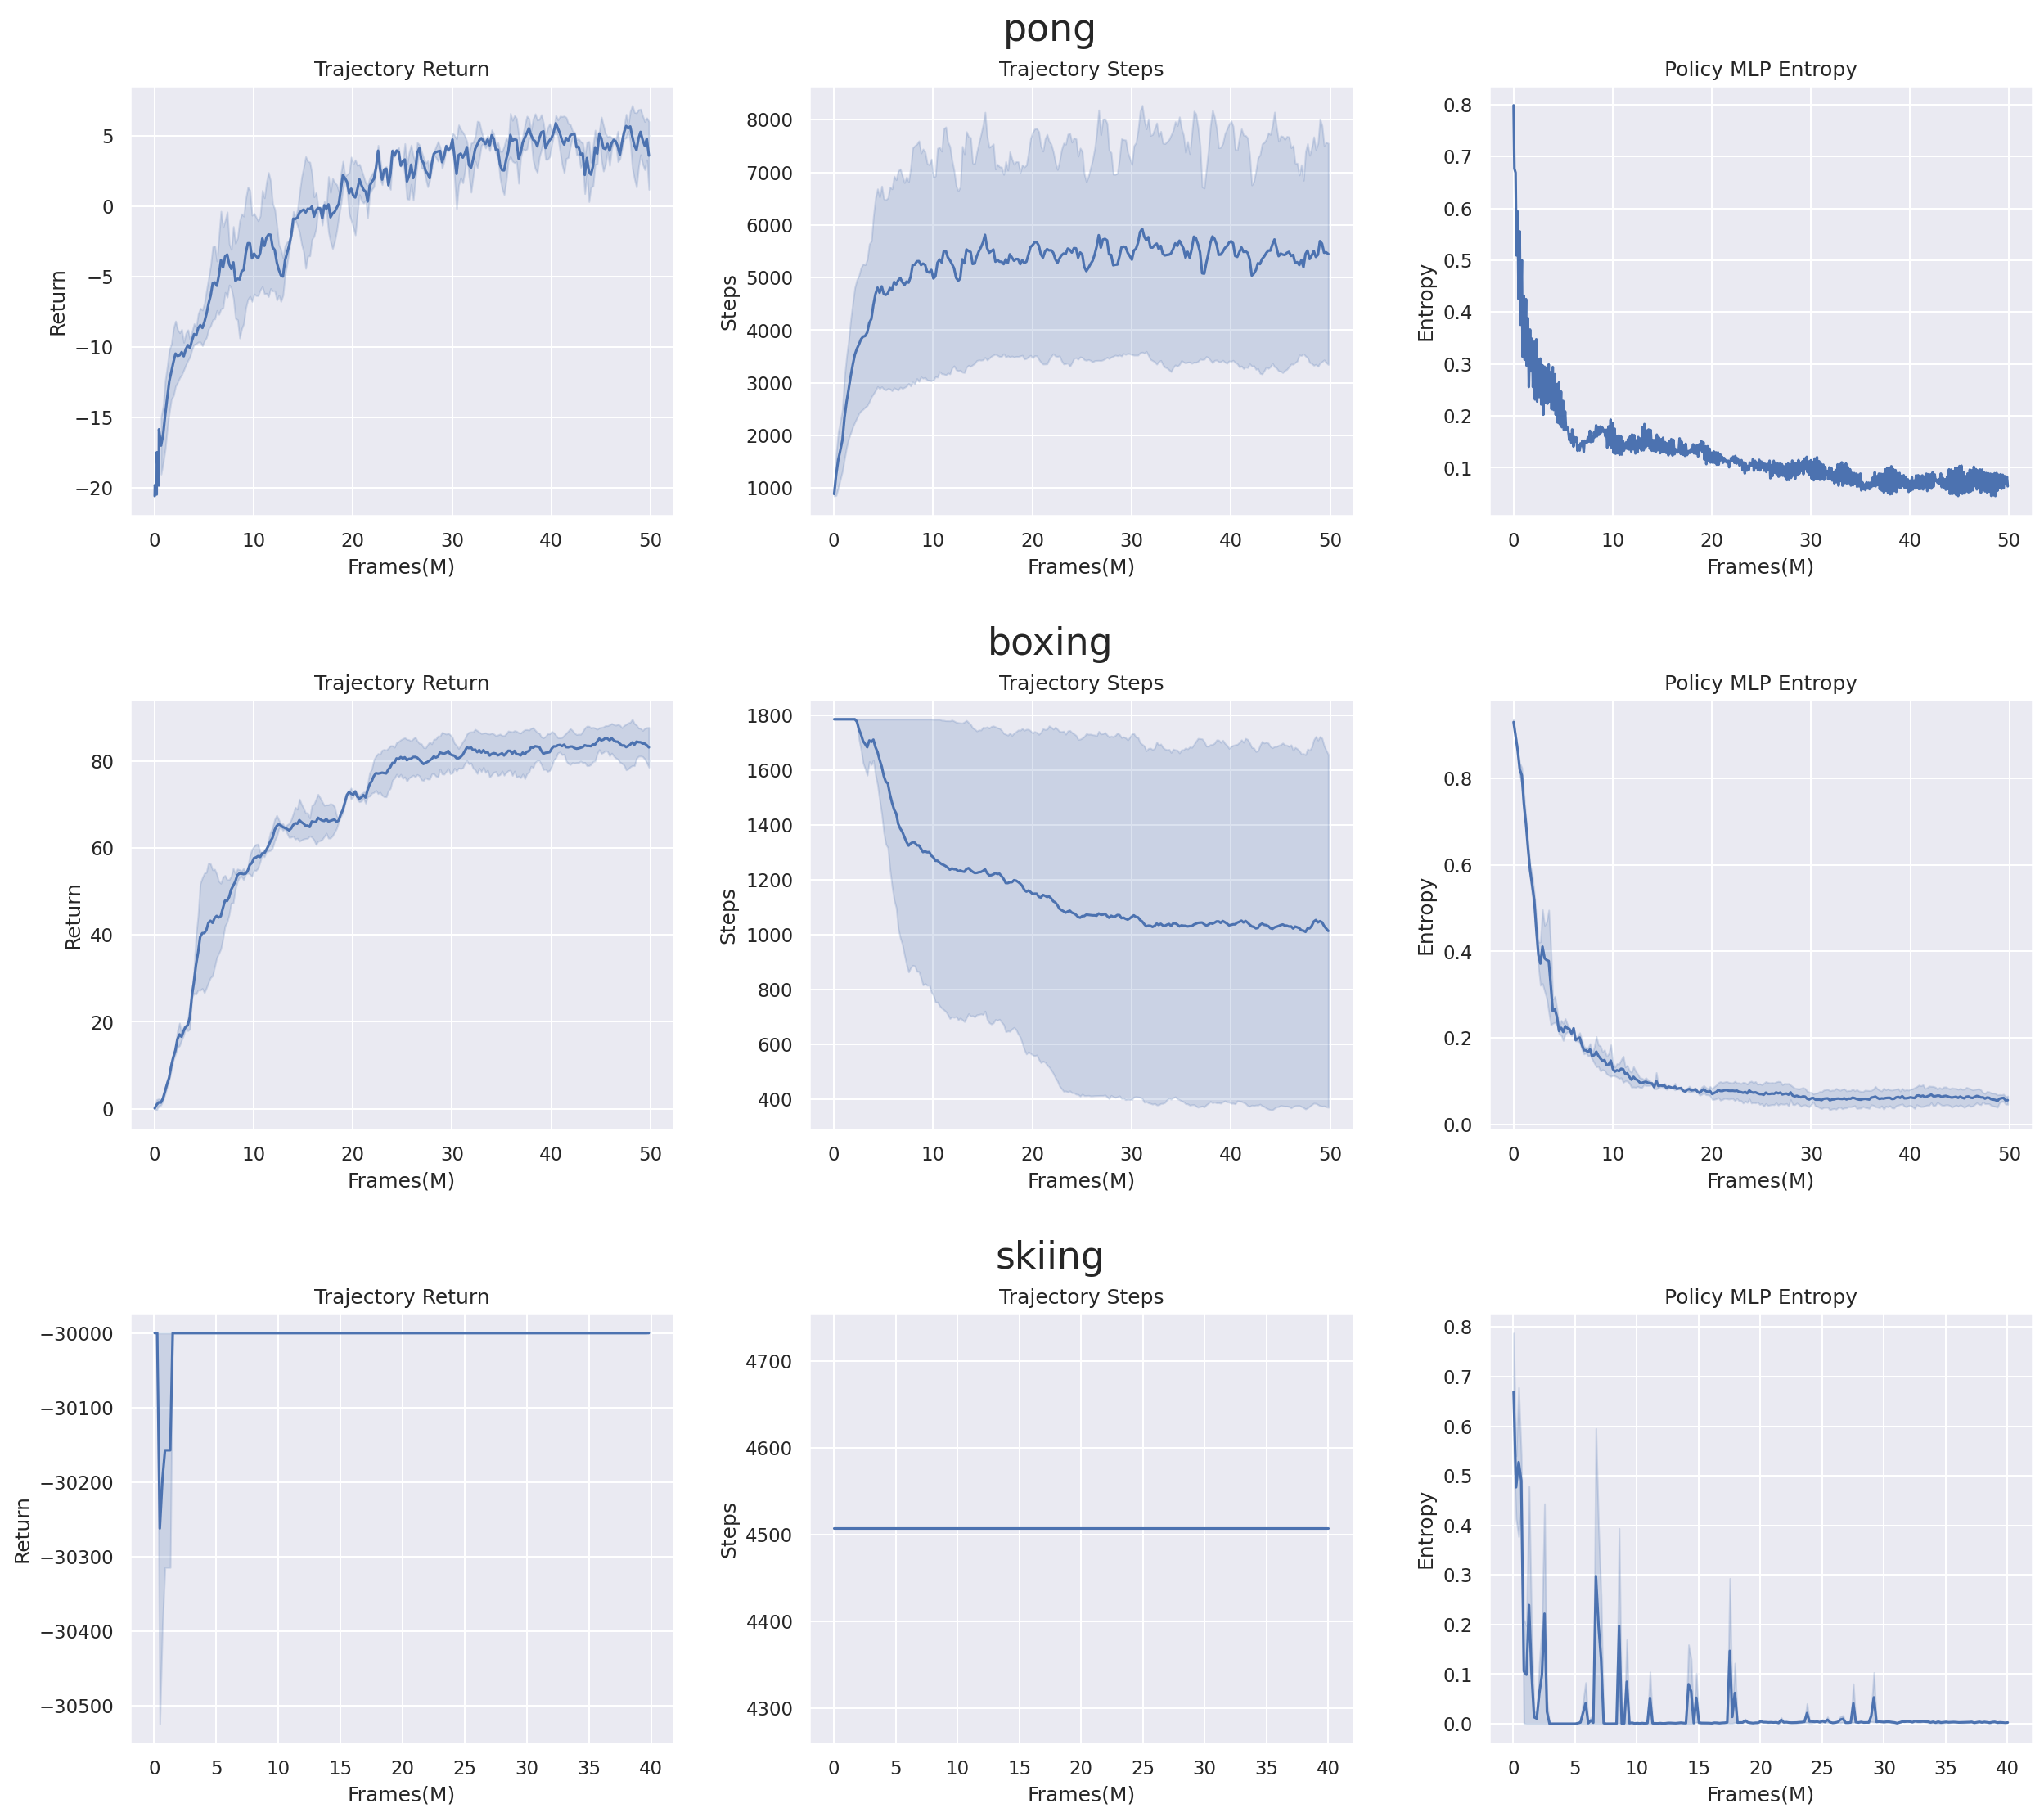

In [4]:
sns.set_theme()

fig_width = 20
no_envs = len(data_to_plot)
width_per_plot = fig_width / 3
fig_size = (fig_width, no_envs * width_per_plot *0.75)
fig = plt.figure(figsize=fig_size, dpi=150)
subfigs = fig.subfigures(no_envs, 1)#, hspace=0.2)
for i, (k, v) in enumerate(data_to_plot.items()):
    subfigs[i].suptitle(str(k), fontsize=22, y=0.92)
    axes = subfigs[i].subplots(1, 3)

    returns_plt = sns.lineplot(data=v["returns"], x="step", y="value", ax=axes[0])
    returns_plt.set(xlabel="Frames(M)", ylabel="Return", title="Trajectory Return")

    steps_plt = sns.lineplot(data=v["steps"], x="step", y="value", ax=axes[1])
    steps_plt.set(xlabel="Frames(M)", ylabel="Steps", title="Trajectory Steps")

    entropys_plt = sns.lineplot(data=v["entropies"], x="step", y="value", ax=axes[2])
    entropys_plt.set(xlabel="Frames(M)", ylabel="Entropy", title="Policy MLP Entropy")
plt.subplots_adjust(top = 0.8, bottom=0.1, hspace= 0, wspace=0.25)
plt.show(fig)
fig.savefig(out_dir / "results.png")
#print(f"{env} with {len(exp_list)} seeds.")